# Attacking CLIP for Image Classification

In this notebook we show how to use the experimental tools in ART to attack the CLIP model.

CLIP is a multimodal foundation model able to handle both images and text. Here we demonstrate how to attack the image recognition portion of CLIP so that it misclassifies a given input.


In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

from art.experimental.estimators.hugging_face_multimodal import HuggingFaceMultiModalPyTorch, HuggingFaceMultiModalInput
from art.experimental.attacks.evasion import CLIPProjectedGradientDescentNumpy

/Users/farhan/Downloads/adversarial-robustness-toolbox/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Image normalization numbers
MEAN = np.asarray([0.48145466, 0.4578275, 0.40821073])
STD = np.asarray([0.26862954, 0.26130258, 0.27577711])

## Load Data

We get sample data from the COCO dataset

In [3]:
# Image IDs for images in the COCO dataset
image_list = ['000000039769.jpg', '000000000285.jpg', '000000002006.jpg', '000000002149.jpg']

# Freetext description of the content of the classes we will try and sort the pictures into.
text = ["a photo of a cat", "a photo of a bear", "a photo of a car", "a photo of a bus", "apples"]

# Ground truth labels mapping the images into one of the free-text categories. 
# Note, we do not have an image of a car in this sample of data
labels = torch.tensor([0, 1, 3, 4])

In [4]:
images = []
for fname in image_list:
    url = 'http://images.cocodataset.org/val2017/' + fname
    images.append(Image.open(requests.get(url, stream=True).raw))

images

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=586x640>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x427>]

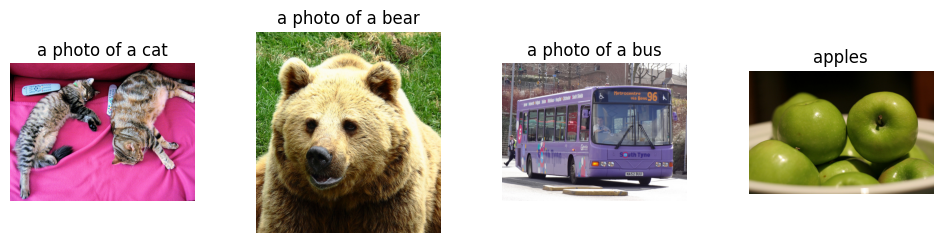

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(10, 4))
fig.tight_layout()
for i, image in enumerate(images):
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title(text[labels[i]])

plt.show()

## Load Model

We will be using a CLIP model from Hugging Face that uses a ViT-B/32 Transformer as the image encoder.

In [6]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [7]:
inputs = processor(text=text, images=images, return_tensors="pt", padding=True)

inputs["pixel_values"].shape

torch.Size([4, 3, 224, 224])

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

classifier = HuggingFaceMultiModalPyTorch(
    model,
    loss=loss_fn,
    clip_values=(inputs['pixel_values'].min(), inputs['pixel_values'].max()),
    input_shape=(3, 224, 224)
)

## Evaluate Model

We first evaluate this model on clean data.

In [10]:
x_clean = HuggingFaceMultiModalInput(**inputs)
clean_outputs = classifier.predict(x_clean)
clean_preds = np.argmax(clean_outputs, axis=1)

clean_acc = np.mean(clean_preds == labels.cpu().detach().numpy())
print('The clean accuracy is:', clean_acc)

100%|██████████| 1/1 [00:00<00:00,  9.61it/s]

The clean accuracy is: 1.0


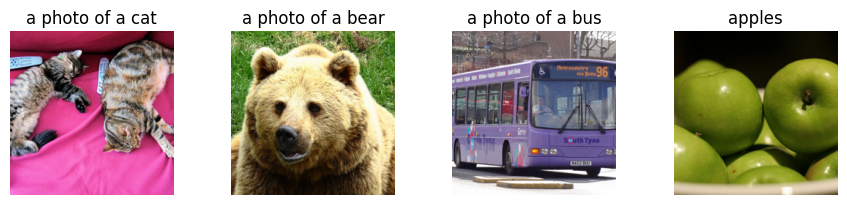

In [11]:
clean_images = np.clip(np.transpose(x_clean['pixel_values'], (0, 2, 3, 1)) * STD + MEAN, 0, 1)

fig, ax = plt.subplots(1, 4, figsize=(9, 4))
fig.tight_layout()
for i in range(4):
    ax[i].imshow(clean_images[i])
    ax[i].axis('off')
    ax[i].set_title(text[clean_preds[i]])

plt.show()

## Evasion Attack

We will perform a Projected Gradient Descent (PGD) evasion attack against the CLIP model.

In [12]:
norm_bound_eps = np.asarray([8 / 255, 8 / 255, 8 / 255]) / STD

attack = CLIPProjectedGradientDescentNumpy(
    classifier,
    max_iter=10,
    eps=np.ones((3, 224, 224)) * np.reshape([norm_bound_eps], (3, 1, 1)),
    eps_step=np.ones((3, 224, 224)) * 0.1,
)

In [13]:
x_adv = attack.generate(x_clean, labels)
adv_outputs = classifier.predict(x_adv)
adv_preds = np.argmax(adv_outputs, axis=1)

adv_acc = np.mean(adv_preds == labels.cpu().detach().numpy())
print('The adversarial accuracy is:', adv_acc)

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 10.37it/s]

The adversarial accuracy is: 0.0


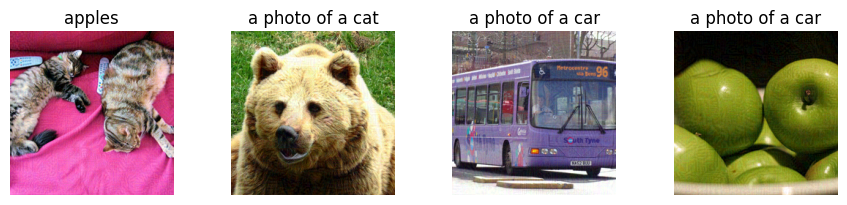

In [14]:
adv_images = np.clip(np.transpose(x_adv['pixel_values'], (0, 2, 3, 1)) * STD + MEAN, 0, 1)

fig, ax = plt.subplots(1, 4, figsize=(9, 4))
fig.tight_layout()
for i in range(4):
    ax[i].imshow(adv_images[i])
    ax[i].axis('off')
    ax[i].set_title(text[adv_preds[i]])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


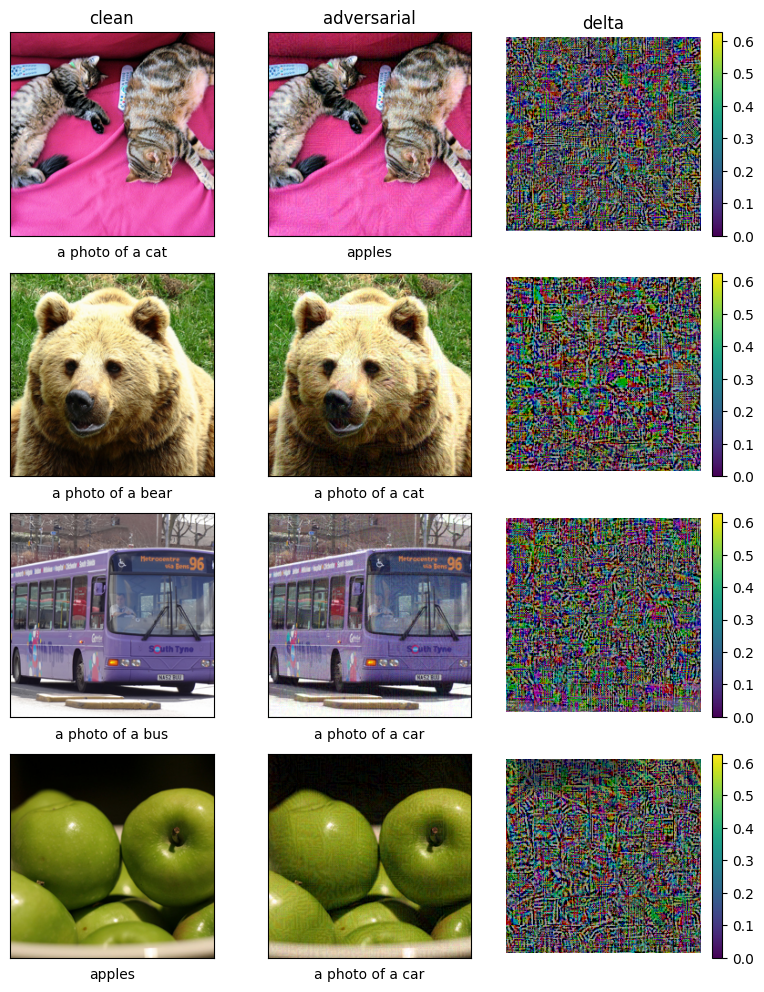

In [15]:
delta = (clean_images - adv_images + 8/255) * 10

fig, axs = plt.subplots(4, 3, figsize=(8, 10))
fig.tight_layout()
for i in range(4):
    axs[i, 0].imshow(clean_images[i])
    axs[i, 0].set_xlabel(text[clean_preds[i]])
    axs[i, 0].tick_params(axis='both', which='both',length=0)
    axs[i, 0].axes.xaxis.set_ticklabels([])
    axs[i, 0].axes.yaxis.set_ticklabels([])
    axs[i, 1].imshow(adv_images[i])
    axs[i, 1].axes.xaxis.set_ticklabels([])
    axs[i, 1].axes.yaxis.set_ticklabels([])
    axs[i, 1].tick_params(axis='both', which='both',length=0)
    axs[i, 1].set_xlabel(text[adv_preds[i]])
    im = axs[i, 2].imshow(delta[i])
    axs[i, 2].axis('off')
    fig.colorbar(im)

axs[0, 0].set_title('clean')
axs[0, 1].set_title('adversarial')
axs[0, 2].set_title('delta')
plt.tight_layout()
plt.show()